## 2017 X-class flare observed with GOES-16: HRC shield rate proxy calibration

From Brian Kress (NOAA affiliate):

<blockquote>
The Sept. 2017 GOES-16 SGPS dataset and comparison plots with GOES-13 and -15 EPS/EPEAD are now available under the "Special Event Data" tab on the NOAA-NCEI website.
<br><br>
https://www.ngdc.noaa.gov/stp/satellite/goes-r.html
<br><br>
ftp://ftp.ngdc.noaa.gov/STP/goesr/solar_proton_events/sgps_sep2017_event_data/
<br><br>
A paper describing SGPS measurements, this dataset and applied corrections will be available soon.
</blockquote>

In particular, Brian verified that
<blockquote>
(...) both G14 and G15 have P5 background rates 0.016-0.019 (p/cm^2-s-sr-MeV), in 2017 to 2020, in the data archived under https://www.ngdc.noaa.gov/stp/satellite/goes/dataaccess.html. Given that G14 and G15 are in agreement in the NCEI data, I expect the lower SWPC G14 backgrounds [that MTA recorded in realtime] are due to some difference in SWPC’s processing of G14 vs. G15, not instrument level differences. My guess is that there was some background subtraction and floor being used on G14, but I’m really not sure of this. Questions about it would have to be directed at SWPC.
</blockquote>

Brian's comment on comparing background levels from different instruments:

<blockquote>
(...) background rates [are] due to GCR [Galactic Cosmic Ray] counts picked up by the high energy tail ("out-of-band") portion of the response function. The EPEAD (and G16 SGPS) differential channels are designed to measure SEP [Solar Energetic Particles] fluxes with a steep spectrum, not GCRs. The background levels are in general different for different instruments (although we do expect them to be similar for the different EPEADs on G13-G15). Actual GCR fluxes at EPEAD P5 energies are ~10^-5 - 10^-4 (p/cm^2-s-sr-MeV), way below the background level. If we see order of magnitude differences between fluxes reported during, e.g., the Sept. 2017 GLE, then there is some problem, but I would not worry too much about comparing background levels from the different EPEADs and SGPSs.
</blockquote>


__Old HRC proxy__<br>
HRC shield rate proxy computed using GOES data available prior to GOES-16, a linear combination of proton fluxes in three channels:<br>
_OLD HRC PROXY = 6000 x P4 + 270000 x P5 + 100000 x P6_

__GOES-16 HRC proxy__<br>
Proxy computed the same coefficients as before but using GOES-16 channels P5, P7, P8A:<br>
_GOES-16 HRC PROXY = 6000 x P5 + 270000 x P7 + 100000 x P8A_

__New HRC proxy__<br>
HRC shield rate proxy derived by fitting the September 2017 telemetry (2SHLDART) with a 4-parameter model:<br>
_NEW HRC PROXY = c0 x P5 + c1 x P7 + c2 x P8A + c3_, where P5, P6, P8A are GOES-16 channels proton channels.

### Data sources used in this analysis

  * GOES-16 SGPS data covering the September 2017 flare, "Special Even Data" tab on the NOAA-NCEI website, https://www.ngdc.noaa.gov/stp/satellite/goes-r.html
  * Corresponding GOES 13/15 EPS/EPEAD realtime data archived by the Chandra Team through Replan Central
  * HRC shield rate from the Chandra telemetry archive (MsIDs: 2SHLDART or 2SHLDBRT)
    
### Summary of the main analysis steps

__Cell 12__<br>
The September 2017 flare profiles observed with OLD GOES satellites and GOES-16. Comparison plots can also be found online on NOAA-NCEI website: ftp://ftp.ngdc.noaa.gov/STP/goesr/solar_proton_events/sgps_sep2017_event_data/

__Cell 16__<br>
HRC shield rate telemetry (2SHLDART, September 2017) and the OLD and GOES-16 proxies. One striking difference is a lower noise level in the GOES-16 proxy compared to the OLD proxy.

__Cell 17__<br>
An arbitrary correction applied to the GOES-16 proxy to account for the lower bgd level of GOES 16 as compared to the earlier GOES satellites and the HRC shield.

__Cell 24__<br>
A 4-parameter model of HRC shield rate derived based on the GOES-16 observation of the 2017 flare. The 4th parameter constitutes an additive term that quantifies the difference in the bgd levels.

__Cell 26__<br>
Application of the new model to the December 2020 HRC shield rate at the time of a C-class flare.

__Cell 31__<br>
Comparison of the old and new proxies as a function of proton flux for various energy channels.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
import matplotlib.pyplot as plt
import tables
from kadi import events
from astropy.time import Time
from Ska.Numpy import interpolate
from Ska.Matplotlib import plot_cxctime
from Ska.engarchive import fetch as fetch
from Chandra.Time import DateTime
from netCDF4 import Dataset as NCDataset

In [2]:
# start and end times for the 2017 flare file
FLARE_START_TIME = '2017-09-01T00:00:00.000'
FLARE_END_TIME = '2017-10-01T00:00:00.000'

# GOES-16 data format constants
RECORDS = 8640
UNITS = 2
CHANNELS = 14
DIFF_CHANNELS = 13

# HRC Proxy (old) coeeficients, AA * chan0 + BB * chan1 + CC * chan2
AA = 6000
BB = 270000
CC = 100000

In [3]:
def convert_j2000_to_chandra_time(times):
    t1 = Time('1998-01-01T00:00:00')
    t2 = Time('2000-01-01T12:00:00')
    dt = t2 - t1  # Difference between two Times
    return times + dt.sec


def get_sgps_g16_proton_data(filename):
    """
    read SGPS Sept. 2017 event data
    B. Kress, Jan. 2021
    """
    # arrays for timestamps and fluxes
    TimeStamp = np.zeros([RECORDS], dtype=np.float64)
    ProtonFluxes = np.zeros([RECORDS, UNITS, CHANNELS], dtype=np.float32)

    # open file and read data set
    ds = NCDataset(filename, mode='r' )
    num_records = len(ds.variables['L2_SciData_TimeStamp'][:])
    TimeStamp[0:num_records] = ds.variables['L2_SciData_TimeStamp'][:]
    ProtonFluxes[0:num_records,:,0:DIFF_CHANNELS] = ds.variables['AvgDiffProtonFlux'][:,:,:]
    ProtonFluxes[0:num_records,:,DIFF_CHANNELS] = ds.variables['AvgIntProtonFlux'][:,:]
    ds.close()
    
    return TimeStamp, ProtonFluxes


def get_arc_goes_data():
    # Retrieve GOES data archived through Replan Central (arc)
    h5_file = "/proj/sot/ska/data/arc3/hrc_shield.h5"
    out = {}

    with tables.open_file(h5_file, mode='r',
                          filters=tables.Filters(complevel=5, complib='zlib')) as h5:
        table = h5.root.data

    h5 = tables.open_file(h5_file, mode='r')
    table = h5.root.data
    
    out['sat'] = table.col('satellite')
    out['secs'] = table.col('time')
    out['p1'] = table.col('p1')
    out['p2a'] = table.col('p2a')
    out['p2b'] = table.col('p2b')
    out['p3'] = table.col('p3')
    out['p4'] = table.col('p4')
    out['p5'] = table.col('p5')
    out['p6'] = table.col('p6')
    out['p7'] = table.col('p7')
    out['p8a'] = table.col('p8a')
    out['p8b'] = table.col('p8b')
    out['p8c'] = table.col('p8c')
    out['p9'] = table.col('p9')
    out['hrc_shield'] = table.col('hrc_shield')
    h5.close()
    
    return out


def calc_HRCProxy(proton_fluxes):
    hrc_proxy = AA * proton_fluxes[0] + BB * proton_fluxes[1] + CC * proton_fluxes[2]
    return hrc_proxy // 256


def plot_format(ax, k):
    plt.yscale('log')
    plt.ylabel('protons/cm$^2$-s-sr-MeV')
    if k == 0:
        textstr = 'SGPS-X (west)'
    elif k == 1:
        textstr = 'SGPS+X (east)'
    ax.text(0.05, 0.97, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top')
    plt.grid()
    plt.legend(loc='upper right', prop={'size': 10})

    
def plot_flare_profiles(k, old_goes, new_goes, color, ylabel=True):
    """
    Compare pre-GOES-16 and GOES-16 channels
    """
    # GOES-16
    plot_cxctime(TimeStamp[:], ProtonFluxes[:, k, new_goes],
                 color=f'C{color}', label=f'{chan_label_g16[new_goes]} GOES-16',
                 alpha=0.7)
    # GOES-13/15, arc a.k.a. Replan Central
    plot_cxctime(goes_arc['secs'], goes_arc[f'p{old_goes}'],
                 color=f'C{color}', label=chan_label_pre_g16[old_goes - 4],
                 alpha=0.3)
    ax = plt.gca()
    plot_format(ax, k)
    plt.xlim(DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate)
    plt.ylim(8e-5, 300)
    if not ylabel:
        plt.ylabel('')

        
def plot_old_new_proxy(k, arc_time_flt,
                               hrcproxy, hrcproxy_correction,
                               shld_dat, shld_time_flt):

    # GOES-13/15, arc a.k.a. Replan Central
    plot_cxctime(goes_arc['secs'][arc2017_flt],
                 goes_arc['hrc_shield'][arc2017_flt],
                 color='lightgray', label="OLD GOES proxy")
    # GOES-16
    plot_cxctime(TimeStamp[:], HRCProxy_2017[:, k] + hrcproxy_correction,
                 color='gray', label="GOES-16 proxy")
    # HRC shield rate, Chandra telemetry
    plot_cxctime(shld2017.times[shld2017_flt], shld2017.vals[shld2017_flt],
                 color='mediumseagreen', marker='.', ls='None', label=f"2SHLDART (HRC shield telemetry)")
    # Limits
    plt.hlines([80], DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate,
               color='gold', linestyle=(0, (10, 4)))
    plt.hlines([250], DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate,
               color='crimson', linestyle=(0, (10, 4)))

    ax = plt.gca()
    plot_format(ax, k)
    plt.ylabel('2SHLDART // 256')

    
def plot_telemetry_proxy_model(arc_time_flt, hrcproxy, hrcproxy_correction,
                               shld_dat, shld_time_flt):
    plot_cxctime(goes_arc['secs'][arc2020_flt], HRCProxy_Cflare + hrcproxy_correction,
             color='gray', label="GOES-16 proxy")
    plot_cxctime(shld2020.times[shld2020_flt], shld2020.vals[shld2020_flt],
             color='mediumseagreen', marker='.', ls='None', label="2SHLDBRT (HRC shield telemetry)")
    x1 = DateTime('2020:329').plotdate
    x2 = DateTime('2020:354').plotdate
    plt.hlines([250], x1, x2, color='crimson', linestyle=(0, (10, 4)))
    plt.hlines([80], x1, x2, color='gold', linestyle=(0, (10, 4)))
    ax = plt.gca()
    plot_format(ax, k)
    plt.xlim([x1, x2])
    plt.ylabel('2SHLDBRT // 256')

    
def plot_proxy_ratio(proxy_ratio, plot_title):
    for chan in (5, 7, 8):
        plt.plot(ProtonFluxes[:, k, chan], proxy_ratio, '.',
                 linestyle='None', label=f'{chan_label_g16[chan]} GOES-16', alpha=0.1)
    plt.loglog()
    plt.grid()
    plt.xlabel('protons/cm$^2$-s-sr-MeV')
    plt.ylabel('GOES-16 proxy / OLD GOES proxy')
    plt.legend()
    plt.ylim(3e-2, 4)
    plt.title(plot_title)

In [4]:
# input file, GOES-16, Sep 2017
# proton fluxes in units of #/cm2-s-sr-keV
# time in j2000
filename = 'g16-flare/se_sgps-l2-avg5m_g16_s20172440000000_e20172732355000_v2_0_0.nc'
TimeStamp, ProtonFluxes = get_sgps_g16_proton_data(filename)

In [5]:
# Convert the times from j2000 to Chandra time
TimeStamp = convert_j2000_to_chandra_time(TimeStamp)
# Convert flux units from #/cm2-s-sr-keV to #/cm2-s-sr-MeV
ProtonFluxes = ProtonFluxes * 1000

In [6]:
# nominal channel energies, GOES-16
chan_label_g16 = ['P1 (1.0-1.9 MeV)', 'P2A (1.9-2.3 MeV)', 'P2B (2.3-3.4 MeV)',\
                  'P3 (3.4-6.5 MeV)', 'P4 (6.5-12 MeV)', 'P5 (12-25 MeV)',\
                  'P6 (25-40 MeV)', 'P7 (40-80 MeV)',\
                  'P8A (83-99 MeV)', 'P8B (99-118 MeV)', 'P8C (118-150 MeV)',\
                  'P9 (150-275 MeV)', 'P10 (275-500 MeV)', 'P11 (>500 MeV)']

In [7]:
"""
Pre-GOES-16 chanels used in HRC proxy calculations:
P4 = Protons from 15-40 MeV units #/cm2-s-sr-MeV
P5 = Protons from 38-82 MeV units #/cm2-s-sr-MeV
P6 = Protons from 84-200 MeV units #/cm2-s-sr-MeV
(old) HRC_PROXY = 6000 x P4 + 270000 x P5 + 100000 x P6
"""

# nominal channel energies for HRC proxy, pre-G16
chan_label_pre_g16 = ['P4 (15-40 MeV)','P5 (38-82 MeV)','P6 (84-200 MeV)']

print("Using the following GOES-16 channels for the HRC proxy comparison:")
for chan in (5, 7, 8):
    print(chan_label_g16[chan])

Using the following GOES-16 channels for the HRC proxy comparison:
P5 (12-25 MeV)
P7 (40-80 MeV)
P8A (83-99 MeV)


In [8]:
# Realtime GOES data archived through Replan Central 
goes_arc = get_arc_goes_data()

In [9]:
# time filters for GOES data archived through Replan Central
arc2017_flt = (goes_arc['hrc_shield'] > 0.1) & \
              (goes_arc['secs'] > DateTime(FLARE_START_TIME).secs) & \
              (goes_arc['secs'] < DateTime(FLARE_END_TIME).secs)

arc2021_flt = (goes_arc['hrc_shield'] > 0.1) & (goes_arc['secs'] > DateTime('2021:001').secs)

arc2020_flt = (goes_arc['hrc_shield'] > 0.1) & \
              (goes_arc['secs'] > DateTime('2020:329').secs) & \
              (goes_arc['secs'] < DateTime('2020:354').secs)

In [10]:
# HRC shield rate from the Chandra telemetry archive, 2SHLD(A/B)RT

# Sep 2017, X-class flare
shld2017 = fetch.Msid('2shldart', start=FLARE_START_TIME, stop=FLARE_END_TIME)
shld2017.vals = shld2017.vals // 256
shld2017_flt = shld2017.vals > 0

# Jan 2021, quiet
shld2021 = fetch.Msid('2shldbrt', start='2021:002', stop='2021:029')
shld2021.vals = shld2021.vals // 256
shld2021_flt = shld2021.vals > 0

# Dec 2020, C/M-class flare
shld2020 = fetch.Msid('2shldbrt', start='2020:329', stop='2020:354')
shld2020.vals = shld2020.vals // 256
shld2020_flt = shld2020.vals > 0

# 2017 X-class flare profile seen by different GOES satellites

In [11]:
# SGPS-X (west) unit
k = 0

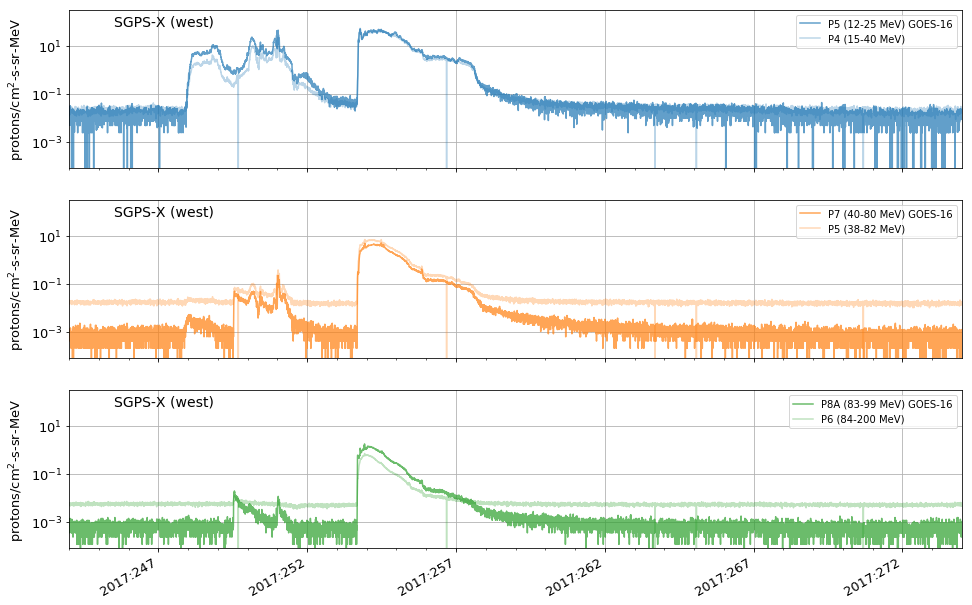

In [12]:
plt.figure(figsize=[16, 11])
plt.subplot(3, 1, 1)
plot_flare_profiles(k, 4, 5, 0)
plt.subplot(3, 1, 2)
plot_flare_profiles(k, 5, 7, 1)
plt.subplot(3, 1, 3)
plot_flare_profiles(k, 6, 8, 2)

__Figure:__ The 2017 strong flare observed with an old generation GOES satellite (Replan Central archive) and a new generation GOES-16 satellite (NOAA website). The "pale" colors represent the three channels on GOES-13/14/15 that were used to compute the HRC shield proxy. The darker colors represent the three GOES-16 channels proposed to replace the old channels. It can be noticed that the background level differs significantly between the old and new GOES instruments (up to > an order of magnitude), and the difference is not constant between the channels. 

Confirming that GOES-16 levels in those three channels before and after the flare are in agreement with the levels observed in Jan 2021:

In [13]:
chans = {5: 'p5', 7: 'p7', 8: 'p8a'}
for key in chans.keys():
    print(chan_label_g16[key],
          # Mean of 100 samples before the 2017 flare
          np.mean(ProtonFluxes[:, k, key][:100]),
          # Mean of 100 samples after the 2017 flare
          np.mean(ProtonFluxes[:, k, key][-100:]),
          # Mean of samples in Jan 2021
          np.mean(goes_arc[chans[key]][arc2021_flt]))

P5 (12-25 MeV) 0.0129387 0.0121133 0.0119721166262
P7 (40-80 MeV) 0.000790953 0.000711229 0.00178981660283
P8A (83-99 MeV) 0.000662636 0.000611664 0.00081301992119


# HRC shield proxy

In [14]:
# HRC proxy, use old coefficients on new GOES-16 channels
proton_fluxes = [ProtonFluxes[:, :, 5],  # P5
                 ProtonFluxes[:, :, 7],  # P7
                 ProtonFluxes[:, :, 8]]  # P8A
HRCProxy_2017 = calc_HRCProxy(np.array(proton_fluxes))

In [15]:
# From kadi database of major events
scs107s = events.scs107s.filter(start='2017:249', stop='2017:258').table
rad_zones = events.rad_zones.filter(start='2017:249', stop='2017:258').table

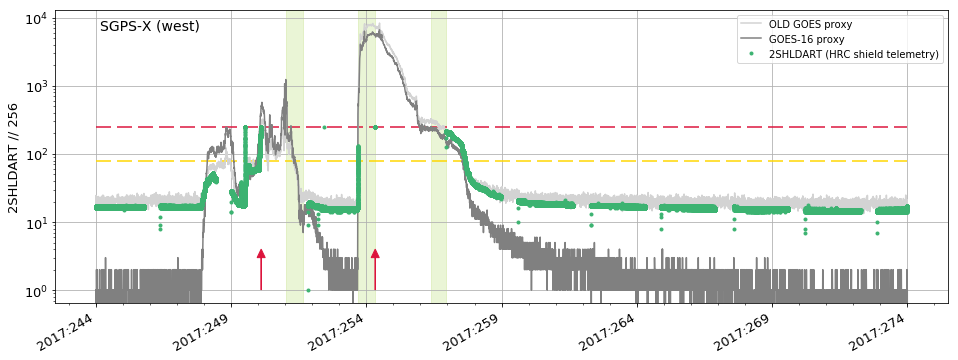

In [16]:
hrcproxy_correction = 0
plt.figure(figsize=[16, 6])
plot_old_new_proxy(k, arc2017_flt, HRCProxy_2017, hrcproxy_correction,
                           shld2017, shld2017_flt)
ax = plt.gca()

for rad_zone in rad_zones:
    x1 = DateTime(rad_zone['start']).plotdate
    x2 = DateTime(rad_zone['stop']).plotdate
    ax.axvspan(x1, x2, alpha=0.2, color='yellowgreen')

for scs107 in scs107s:
    plt.arrow(DateTime(scs107['start']).plotdate, 1, 0, 2,
              head_width=0.3, head_length=1, color='crimson')

__Figure:__ Chandra's HRC shield rate telemetry __(green)__ and its proxies: __(light gray)__ computed using the OLD GOES data and __(dark gray)__ computed using the GOES-16 data. __The same old coefficients used for both proxies.__ The yellow dashed line marks MTA's yellow alert limit. The red dashed line marks 250 counts/sample at which RADMON will trigger SCS 107 (SI safing action). The red arrows mark the two instances of SCS 107 run over the considered time period. Shaded areas mark radiation zones between the first radiation shutdown and day 2017:257 (recovery from the second radiation shutdown). As expected, the difference in bgd level between the two generations of the GOES satellites translates into the difference in the noise level of HRC proxies. This can be interpreted as a signature of the bgd level difference between the HRC and GOES-16, indicating a need of a 4th additive parameter in the HRC proxy equation.

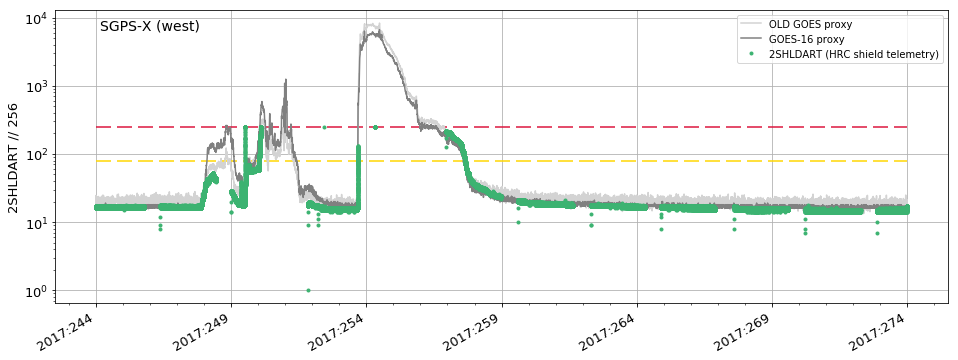

In [17]:
hrcproxy_correction = 16

plt.figure(figsize=[16, 6])
plot_old_new_proxy(k, arc2017_flt, HRCProxy_2017, hrcproxy_correction,
                           shld2017, shld2017_flt)

__Figure:__ The same as in the cell above but GOES-16 HRC proxy contains the 4th additive term, hrcproxy_correction = 16.

## Fit a 4-parameter HRC shield rate model

In [18]:
# Interpolate GOES-16 data on the 2SHLDBRT time axis
g16_p5_intrpl = interpolate(ProtonFluxes[:, k, 5], TimeStamp,
                            shld2017.times[shld2017_flt], method='linear')
g16_p7_intrpl = interpolate(ProtonFluxes[:, k, 7], TimeStamp,
                            shld2017.times[shld2017_flt], method='linear')
g16_p8a_intrpl = interpolate(ProtonFluxes[:, k, 8], TimeStamp,
                             shld2017.times[shld2017_flt], method='linear')

In [19]:
from sherpa.astro import ui

In [20]:
# Coefficients in the OLD HRC proxy equation
AA, BB, CC

(6000, 270000, 100000)

In [21]:
# Fitting

pars0 = [AA, BB, CC, 16]

def hrc_shield_proxy(pars, ch0, ch1, ch2):
    c0, c1, c2, c3 = pars
    return c0 * ch0 + c1 * ch1 + c2 * ch2 + c3


def hrc_shield_proxy_model(ch0, ch1, ch2):
    
    def sherpa_func(pars, x=None):
        return hrc_shield_proxy(pars, ch0, ch1, ch2)
    
    return sherpa_func


def fit_hrc_proxy(times, vals):
    data_id = 1
    nn = 4
    comp_names = [f'c{i}' for i in range(nn)]
    ui.set_method('simplex')
    ui.set_stat('chi2modvar')    
    
    ch0 = g16_p5_intrpl
    ch1 = g16_p7_intrpl
    ch2 = g16_p8a_intrpl
    ui.load_user_model(hrc_shield_proxy_model(ch0, ch1, ch2), 'model')
        
    ui.add_user_pars('model', comp_names)
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(times), np.array(vals))

    # Initial fit values
    fmod = ui.get_model_component('model')
    for i in range(nn):
        comp_name = f'c{i}'
        setattr(fmod, comp_name, pars0[i])
        comp = getattr(fmod, comp_name)
        comp.max = 3e5
        comp.min = 0
        
    ui.fit(data_id)
    #conf = ui.get_confidence_results()
    return ui.get_fit_results()

In [22]:
res = fit_hrc_proxy(shld2017.times[shld2017_flt], shld2017.vals[shld2017_flt])

Dataset               = 1
Method                = neldermead
Statistic             = chi2modvar
Initial fit statistic = 8.32457e+08
Final fit statistic   = 1.45227e+06 at function evaluation 1836
Data points           = 211220
Degrees of freedom    = 211216
Probability [Q-value] = 0
Reduced statistic     = 6.87575
Change in statistic   = 8.31005e+08
   model.c0       8.29087     
   model.c1       661.28      
   model.c2       5992.81     
   model.c3       11.9119     


In [23]:
AA, BB, CC

(6000, 270000, 100000)

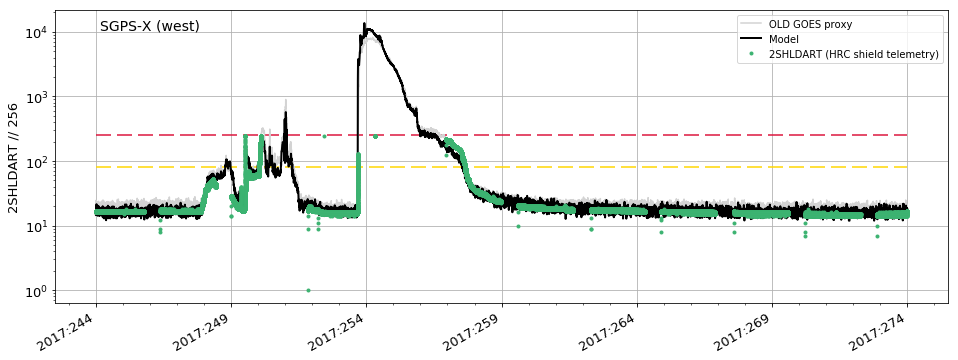

In [24]:
hrcproxy_correction = 0

plt.figure(figsize=[16, 6])

# OLD proxy
plot_cxctime(goes_arc['secs'][arc2017_flt],
             goes_arc['hrc_shield'][arc2017_flt],
             color='lightgray', label="OLD GOES proxy")

# HRC shield rate new proxy model (new data, new coefficients)
model_2017 = hrc_shield_proxy(res.parvals,
                              ProtonFluxes[:, k, 5],
                              ProtonFluxes[:, k, 7],
                              ProtonFluxes[:, k, 8])
plot_cxctime(TimeStamp, model_2017, '-', lw=2,
             color='k', label='Model')

# HRC shield rate, Chandra telemetry
plot_cxctime(shld2017.times[shld2017_flt], shld2017.vals[shld2017_flt],
             color='mediumseagreen', marker='.', ls='None', label=f"2SHLDART (HRC shield telemetry)")

# Limits
plt.hlines([80], DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate,
           color='gold', linestyle=(0, (10, 4)))
plt.hlines([250], DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate,
           color='crimson', linestyle=(0, (10, 4)))

ax = plt.gca()
plot_format(ax, k)
plt.ylabel('2SHLDART // 256');

### Application to the December 2020 C-class flare

In [25]:
# HRC proxy at the time of the C/M Dec 2020 class flare
# using old coefficients on new G16 channels
proton_fluxes = [goes_arc['p5'][arc2020_flt],
                 goes_arc['p7'][arc2020_flt],
                 goes_arc['p8a'][arc2020_flt]]
HRCProxy_Cflare = calc_HRCProxy(proton_fluxes)

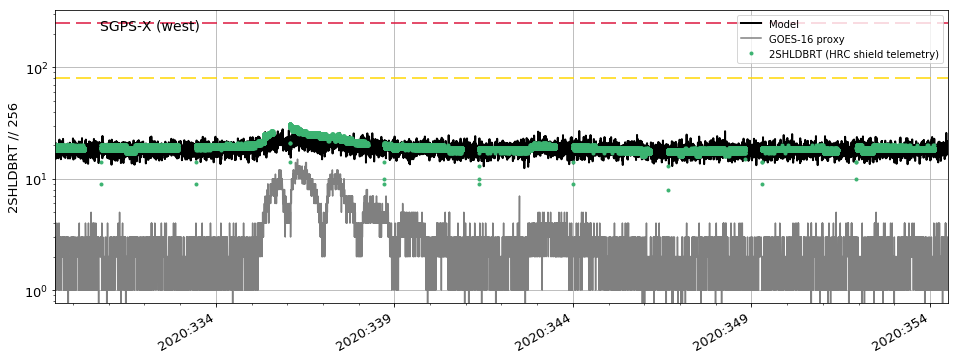

In [26]:
plt.figure(figsize=[16, 6])

# HRC shield rate new proxy model (new data, new coefficients)
model_2020 = hrc_shield_proxy(res.parvals,
                              proton_fluxes[0],
                              proton_fluxes[1],
                              proton_fluxes[2])
plot_cxctime(goes_arc['secs'][arc2020_flt], model_2020, '-', lw=2,
             color='k', label='Model')

# No refitting, no bgd level correction
hrcproxy_correction = 0
plot_telemetry_proxy_model(arc2020_flt, HRCProxy_Cflare, hrcproxy_correction,
                           shld2020, shld2020_flt)

__Figure:__ GOES-16 HRC proxy (linear combination of GOES-16 channels with old coefficients) and the new 4-parameter HRC shield rate model compared with the Chandra telemetry at the time of the December 2020 C-class flare .

## Ratio of NEW to OLD proxy vs proton flux

In [27]:
# Interpolate arc (Replan Central) HRC shield rate proxy
# on the time axis of the NOAA G16 data
yout = interpolate(goes_arc['hrc_shield'][arc2017_flt], goes_arc['secs'][arc2017_flt], TimeStamp[:])

In [28]:
proxy_ratio = HRCProxy_2017[:, k] / yout

In [29]:
hrcproxy_correction = 16
proxy_ratio_bgd_corrected = (HRCProxy_2017[:, k] + hrcproxy_correction) / yout

In [30]:
proxy_ratio_new_fit = model_2017 / yout

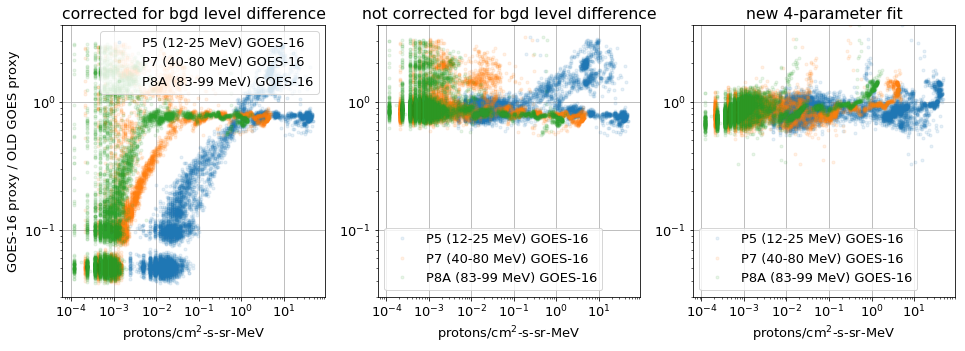

In [31]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plot_proxy_ratio(proxy_ratio, 'corrected for bgd level difference')

plt.subplot(1, 3, 2)
plot_proxy_ratio(proxy_ratio_bgd_corrected, 'not corrected for bgd level difference')
plt.ylabel('')

plt.subplot(1, 3, 3)
plot_proxy_ratio(proxy_ratio_new_fit, 'new 4-parameter fit')
plt.ylabel('');

__Figure:__ The apparent dependence of the proxy ratio on proton flux appears to be due to the difference in the backgorund level between the old and new generation of GOES satellites.